<a href="https://colab.research.google.com/github/aghapygad336/Image-Segmentation/blob/master/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import math
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from urllib.request import urlretrieve
import cv2
import os
import glob
import pandas as pd

In [2]:
if not os.path.isfile('BSR_bsds500.tgz'):
    urlretrieve('http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz','BSR_bsds500.tgz')
if not os.path.isfile('content/BSR_bsds500.tgz'):
    !apt-get install p7zip-full
    !p7zip -d BSR_bsds500.tgz
    !tar -xvf BSR_bsds500.tgz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/bin/p7zip: BSR_bsds500.tgz: unknown suffix
BSR/
BSR/documentation/
BSR/documentation/Arbelaez_Maire_Fowlkes_Malik_TPAMI2010.pdf
BSR/bench/
BSR/bench/source/
BSR/bench/source/match.hh
BSR/bench/source/Matrix.cc
BSR/bench/source/Timer.cc
BSR/bench/source/csa_types.h
BSR/bench/source/csa.cc
BSR/bench/source/correspondPixels.cc
BSR/bench/source/build.sh
BSR/bench/source/match.cc
BSR/bench/source/Sort.hh
BSR/bench/source/csa_defs.h
BSR/bench/source/Timer.hh
BSR/bench/source/Exception.cc
BSR/bench/source/String.cc
BSR/bench/source/Array.hh
BSR/bench/source/kofn.hh
BSR/bench/source/Random.hh
BSR/bench/source/Exception.hh
BSR/bench/source/.gitignore
BSR/bench/source/kofn.cc
BSR/bench/source/build.m
BSR/bench/source/Random.cc
BSR/bench/source/Point.hh
BSR/bench/source/README
B

Image Dimension    :  (321, 481, 3)
Image Height       :  321
Image Width        :  481
Number of Channels :  3
Number of Pixels   :  154401


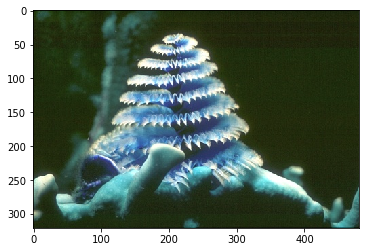

In [3]:
import numpy as np
from os import listdir
from os.path import isfile, join
import cv2

imagesFile_path = "BSR/BSDS500/data/images/train/"
imagesFile = [f for f in listdir(imagesFile_path) if isfile(join(imagesFile_path, f)) and f.endswith(".jpg")]
sortedImgfiles=sorted(imagesFile)


data = []

for i in range(len(sortedImgfiles)):
    testPlot=imagesFile_path+sortedImgfiles[i]
    img = cv2.imread(testPlot, cv2.IMREAD_UNCHANGED)

# get dimensions of image
    dimensions = img.shape
# height, width, number of channels in image
    height = img.shape[0]
    width = img.shape[1]
    channels = img.shape[2]
    numberTotalPixels=height*width
    data.append(img)
    mydata = np.array(data)

print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)
print('Number of Pixels   : ',numberTotalPixels)
plt.imshow(mydata[20])
plt.show()


Extract Ground Truth

Number Of C : 5
W : Segmentation
J : 0
(321, 481)


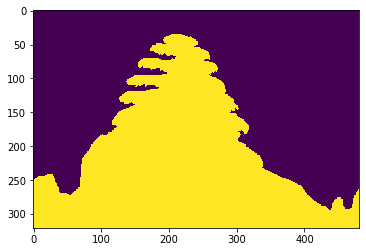

W : Boundaries
J : 1
(321, 481)


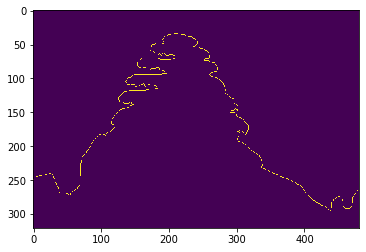

W : Segmentation
J : 0
(321, 481)


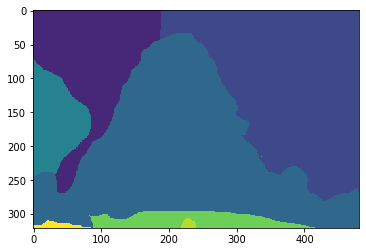

W : Boundaries
J : 1
(321, 481)


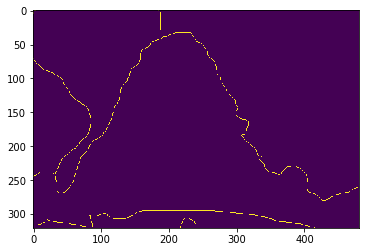

W : Segmentation
J : 0
(321, 481)


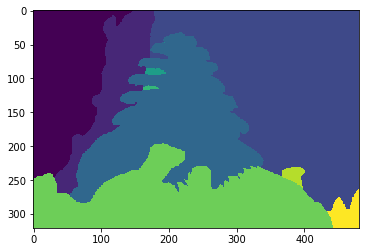

W : Boundaries
J : 1
(321, 481)


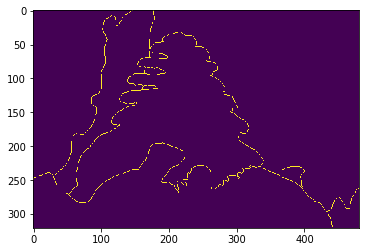

W : Segmentation
J : 0
(321, 481)


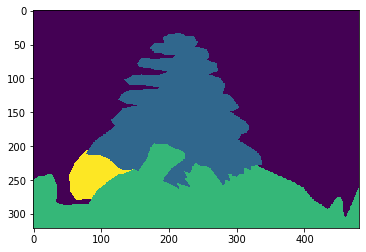

W : Boundaries
J : 1
(321, 481)


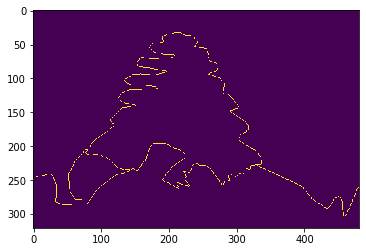

W : Segmentation
J : 0
(321, 481)


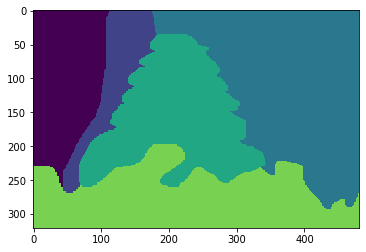

W : Boundaries
J : 1
(321, 481)


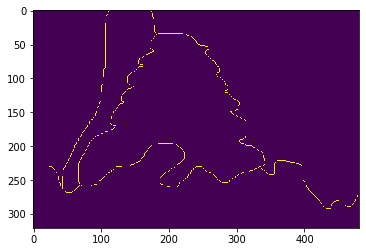

list

In [4]:
import scipy.io 

def load_bsd_gt(filename):
    gt = scipy.io.loadmat(filename);
    # scipy.io.loadmat()
    gt = gt['groundTruth']
    what = ['Segmentation','Boundaries']

    cols = (gt.shape[1])
    print("Number Of C :",cols)

    ret = list()

    for xx in range(cols):
        j=0
        tmp = list()
        for w in what:
            print("W :",w)
            print("J :",j)
            tmp.append(gt[0][xx][w][0][0][:])
            arr_gt=np.array(tmp[j])
            print(arr_gt.shape)
            j=j+1
            plt.imshow(arr_gt)
            plt.show()
            ret.append(tmp)
    return ret
groundTruth_path = "BSR/BSDS500/data/groundTruth/train/"
groundTruthFile = [f for f in listdir(groundTruth_path) if isfile(join(groundTruth_path, f)) and f.endswith(".mat")]
sortedGroundTruthFile=sorted(groundTruthFile)

testPlot_=groundTruth_path+sortedGroundTruthFile[20]

arr_gt=load_bsd_gt(testPlot_)
type(arr_gt)

 ***Color Quantization*** is the process of reducing number of colors in an image. One reason to do so is to reduce the memory. Sometimes, some devices may have limitation such that it can produce only limited number of colors. In those cases also, color quantization is performed. Here we use **k-means clustering for color quantization**. italicized text

**`K-Means`**

In [0]:
import random
from PIL import Image


def change_clusters_if_needed(clusters, image):
  '''
  :param clusters: cluster dicts in the form {center: [colors]}
  :return: the clusters after convergence is reached
  '''
  new_centers = []
  something_changed = False
  for center in clusters:
    colors = clusters[center]
    average = get_average_color(colors)
    if average != center:
      something_changed = True
    new_centers.append(average)
  if something_changed:
    new_empty_clusters = create_cluster_dict(new_centers)
    new_populated_clusters = populate_clusters(image, new_empty_clusters, new_centers)
    return change_clusters_if_needed(new_populated_clusters, image)
  else:
    return clusters




In [0]:


def get_average_color(colors):
  '''
  :param colors: a list of colors in the form [(R, G, B)]
  :return: a color in the form (R, G, B)
  '''
  num_colors = len(colors)
  if num_colors == 0:
    return (0, 0, 0)
  r, g, b = 0, 0, 0
  for color in colors:
    r += color[0]
    g += color[1]
    b += color[2]
  return(int(r/num_colors), int(g/num_colors), int(b/num_colors))



In [0]:



def populate_clusters(image, clusters, centers):
  '''
  :param image: the image for which we are creating the clusters
  :param clusters: default cluster dict where the key is the center and the value is the list of colors in the cluster
  :param centers: a list of the colors that we are using to cluster
  :return: the cluster dict after populating with colors in the image
  '''
  for y in range(image.height):
    for x in range(image.width):
      color = image.getpixel((x, y))
      center = get_nearest_center(color, centers)
      clusters[center].append(color)
  return clusters



In [0]:

def get_nearest_center(color, centers):
  '''
  :param color: a color in the form (R, G, B)
  :param centers: a list of colors
  :return: the center that is closet to color according to distance_between_colors
  '''
  nearest_center = centers[0]
  shortest_distance = distance_between_colors(color, centers[0])
  for c in centers[1:]:
    distance = distance_between_colors(color, c)
    if distance < shortest_distance:
      shortest_distance = distance
      nearest_center = c
  return nearest_center




In [0]:


def get_random_colors(image, n):
  '''
  :param image: the image in which we are getting n random pixels
  :param n: the number of random pixels
  :return: a list of n pairs, each of which contains an (x, y) coordinate
  '''
  initial_colors = []
  while(len(initial_colors) < n):
    x = random.randint(0, image.width)
    y = random.randint(0, image.height)
    color = image.getpixel((x, y))
    initial_colors.append(color)
  return initial_colors




In [0]:

def distance_between_colors(color1, color2):
  '''
  :param color1: a color in the format (R, G, B)
  :param color2: a color in the format (R, G, B)
  :return: a floating point number representing the color space distance between color1 and color2
  '''
  sum = 0
  for index in range(3):
    sum += (color1[index] - color2[index])**2
  return sum ** (1/2)


In [0]:


def populate_image_from_clusters(image, clusters):
  '''
  :param image: a blank image whose pixels' colors will be set
  :param clusters: the groups of similar pixels in a dict object
  :return: nothing, this function edits 'image'
  '''
  centers = list(clusters.keys())
  for y in range(image.height):
    for x in range(image.width):
      old_color = image.getpixel((x, y))
      closest_center = get_nearest_center(old_color, centers)
      image.putpixel((x, y), closest_center)



In [0]:
def create_cluster_dict(centers):
  d = {}
  for c in centers:
    d[c] = []
  return d

In [0]:
testPlot=imagesFile_path+sortedImgfiles[20]
filename = testPlot
input_image = Image.open(filename)


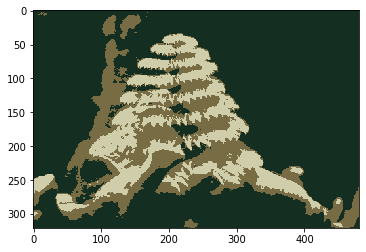

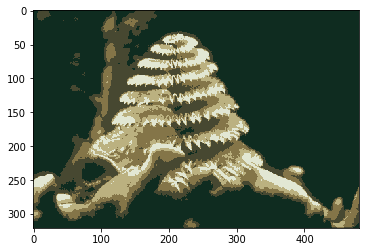

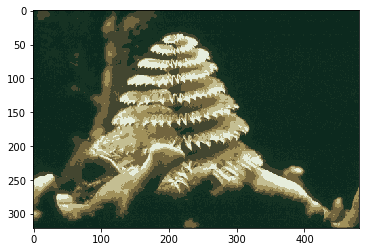

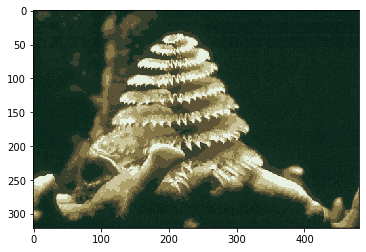

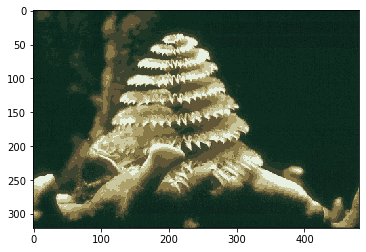

In [23]:
data_new_image=[]
data_final_clusters=[]
Kmeans_=[3,5,7,9,11]
for k in range(3,12,2):  
  
    input_image = Image.open(filename)
    default_colors = get_random_colors(input_image,k)
    default_cluster = create_cluster_dict(default_colors)
    clusters = populate_clusters(input_image, default_cluster, default_colors)
    final_clusters = change_clusters_if_needed(clusters, input_image)
    new_image = input_image.copy()
    populate_image_from_clusters(new_image, final_clusters)
    data_new_image.append(new_image)
    data_final_clusters.append(final_clusters)
    plt.imshow(new_image)
    plt.show() 



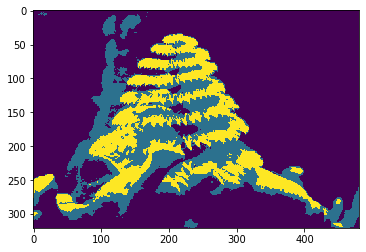

(321, 481)


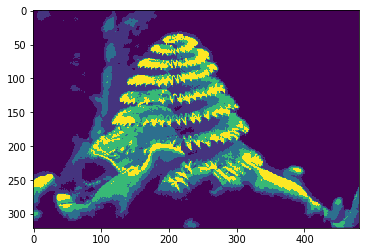

(321, 481)


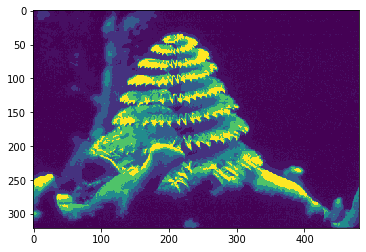

(321, 481)


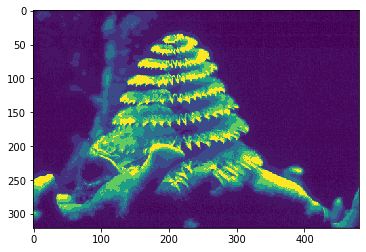

(321, 481)


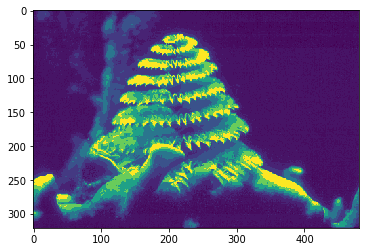

(321, 481)


In [25]:
import numpy as np

from PIL import Image
p=[]
for i in range(0,5):  
    a = np.array(data_new_image[i].getdata()).astype(np.float32).reshape( (new_image.size[1],new_image.size[0],3) )
    gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
    import math
    p=np.ceil(gray)
    plt.imshow(p)
    plt.show()
    print(p.shape)

**F-measure**

In [0]:
from sklearn.metrics.cluster import contingency_matrix
true_ = p.flatten()
prediction_ = arr_gt[0][0].flatten()
cont = contingency_matrix(prediction_, true_)
contingency = cont.T
Actual_P = np.sum(contingency,axis=0)
Actual_N = np.sum(contingency,axis =1)
prec = []
recall =[]
count = 0
for i in contingency:
    prec = np.append(prec,(max(i)/Actual_N[count]))
    recall = np.append(recall,(max(i)/Actual_P[np.argmax(i)]))
    count+=1


In [21]:
f1_measure = (2*prec *recall)/(prec+recall)
total_f1_measure = (1/len(f1_measure))* np.sum(f1_measure)
print('Fmeasure Value = ',total_f1_measure)
print('For K =' ,Kmeans_[0])

Fmeasure Value =  0.596115873944384
For K = 3


**Conditional Entropy**

In [22]:
true_ = p.flatten()
prediction_ = arr_gt[0][0].flatten()
cont = contingency_matrix(prediction_, true_)
contingency = cont.T
ni = np.sum(contingency,axis =1)
n = np.sum(ni)

count = 0
centroids_entropy = []

for i in contingency:
    c = 0
    for j in range(contingency.shape[1]):
        c = c -(i[j]/ni[count])*np.log2(i[j]/ni[count])
    centroids_entropy.append(c)
    count +=1
entropy = 0 
for i in centroids_entropy:
    entropy +=(ni[centroids_entropy.index(i)]/n)*i
print("Conditional entropy",entropy)

Conditional entropy 0.6745369748167099
